## 第五周：pytorch训练过程。学习率调整策略，TensorBoardX，训练曲线， 特征图可视化，卷积核可视化等

### 01、Hook 函数概念

Hook 函数是在不改变主体的情况下，实现额外功能。由于 PyTorch 是基于动态图实现的，因此在一次迭代运算结束后，一些中间变量如非叶子节点的梯度和特征图，会被释放掉。在这种情况下想要提取和记录这些中间变量，就需要使用 Hook 函数

#### PyTorch 提供了 4 种 Hook 函数

#### torch.Tensor.register_hook(hook)
- 功能：注册一个反向传播 hook 函数，仅输入一个参数，为张量的梯度。

- hook函数：
    - hook(grad)
    - 参数：grad：张量的梯度

In [6]:
import torch
# 创建张量
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)
a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

# 保存梯度的 list
a_grad = list()

# 定义 hook 函数，把梯度添加到 list 中
def grad_hook(grad):
    a_grad.append(grad)

# 一个张量注册 hook 函数
handle = a.register_hook(grad_hook)

y.backward()

# 查看梯度：除了叶子节点，其他节点会被清空
print("gradient:", w.grad, x.grad, a.grad, b.grad, y.grad)
# 查看在 hook 函数里 list 记录的梯度
print("a_grad[0]: ", a_grad[0])
handle.remove()

gradient: tensor([5.]) tensor([2.]) None None None
a_grad[0]:  tensor([2.])


D:\anaconda\envs\torch_tf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


在反向传播结束后，非叶子节点张量的梯度被清空了。而通过hook函数记录的梯度仍然可以查看。

hook函数里面可以修改梯度的值，无需返回也可以作为新的梯度赋值给原来的梯度。代码如下：

In [7]:
import torch
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)
a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

a_grad = list()

def grad_hook(grad):
    grad *= 2
    return grad*3

handle = w.register_hook(grad_hook)

y.backward()

# 查看梯度
print("w.grad: ", w.grad)
handle.remove()

w.grad:  tensor([30.])


#### torch.nn.Module.register_forward_hook(hook)
- 功能：注册 module 的前向传播hook函数，可用于获取中间的 feature map。
- hook函数：
    - hook(module, input, output)
    - 参数：
    - module：当前网络层
    - input：当前网络层输入数据
    - output：当前网络层输出数据

下面代码执行的功能是 $3 \times 3$ 的卷积和 $2 \times 2$ 的池化。我们使用register_forward_hook()记录中间卷积层输入和输出的 feature map。

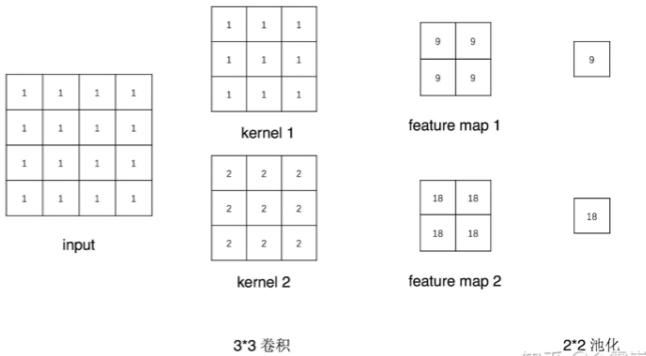

In [15]:
import torch.nn as nn
# 定义一个网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积3x3
        self.conv1 = nn.Conv2d(1, 2, 3)
        # 池化2x2
        self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        return x
    
# hook函数：对卷积的hook
def forward_hook(module, data_input, data_output):
    output_block.append(data_output)
    input_block.append(data_input)
    
    
    
# hook函数：对池化的hook
def forward_hook2(module, data_input, data_output):
    output_block2.append(data_output)
    input_block2.append(data_input)
    
# 初始化网络
net = Net()
# 第一个卷积核的权重
net.conv1.weight[0].detach().fill_(1)
# 第二个卷积核的权重
net.conv1.weight[1].detach().fill_(2)
# 卷积核的偏置
net.conv1.bias.data.detach().zero_()

# 注册hook：卷积的hook
output_block = list()
input_block = list()
# 第一个卷积层使用钩子函数
net.conv1.register_forward_hook(forward_hook)

# 注册hook：池化的hook
output_block2 = list()
input_block2 = list()
# 第一个池化层使用钩子函数
net.pool1.register_forward_hook(forward_hook2)

# inference
fake_img = torch.ones((1, 1, 4, 4))   # batch size * channel * H * W
output = net(fake_img)


# 卷积的输入
print("input shape: {}\ninput value: {}".format(input_block[0][0].shape, input_block[0]))
# 卷积的输出
print("feature maps shape: {}\noutput value: {}\n".format(output_block[0].shape, output_block[0]))

# 池化的输入
print("input shape: {}\ninput value: {}".format(input_block2[0][0].shape, input_block2[0]))
# 池化的输出
print("feature maps shape: {}\noutput value: {}\n".format(output_block2[0].shape, output_block2[0]))

# 网络输出结果
print("output shape: {}\noutput value: {}\n".format(output.shape, output))



# 卷积的输入为原图，卷积的输出（特征图）为池化的输入，池化的输出（特征图）为最终结果
# 具体的可以debug查看原因

input shape: torch.Size([1, 1, 4, 4])
input value: (tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]]),)
feature maps shape: torch.Size([1, 2, 2, 2])
output value: tensor([[[[ 9.,  9.],
          [ 9.,  9.]],

         [[18., 18.],
          [18., 18.]]]], grad_fn=<ThnnConv2DBackward>)

input shape: torch.Size([1, 2, 2, 2])
input value: (tensor([[[[ 9.,  9.],
          [ 9.,  9.]],

         [[18., 18.],
          [18., 18.]]]], grad_fn=<ThnnConv2DBackward>),)
feature maps shape: torch.Size([1, 2, 1, 1])
output value: tensor([[[[ 9.]],

         [[18.]]]], grad_fn=<MaxPool2DWithIndicesBackward>)

output shape: torch.Size([1, 2, 1, 1])
output value: tensor([[[[ 9.]],

         [[18.]]]], grad_fn=<MaxPool2DWithIndicesBackward>)



#### torch.Tensor.register_forward_pre_hook()
- 功能：注册 module 的前向传播前的hook函数，可用于获取输入数据。
- hook函数：
    - hook(module, input)
    - 参数：
    - module：当前网络层
    - input：当前网络层输入数据

#### torch.Tensor.register_backward_hook()
- 功能：注册 module 的反向传播的hook函数，可用于获取梯度。
- hook函数：
    - hook(module, grad_input, grad_output)
    - 参数：
    - module：当前网络层
    - input：当前网络层输入的梯度数据
    - output：当前网络层输出的梯度数据

In [20]:
import torch.nn as nn

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1, 2, 3)
            self.pool1 = nn.MaxPool2d(2, 2)

        def forward(self, x):
            x = self.conv1(x)
            x = self.pool1(x)
            return x

def forward_pre_hook(module, data_input):
    print("forward_pre_hook input:{}".format(data_input))

def backward_hook(module, grad_input, grad_output):
    print("backward hook input:{}".format(grad_input))
    print("backward hook output:{}".format(grad_output))

# 初始化网络
net = Net()
net.conv1.weight[0].detach().fill_(1)
net.conv1.weight[1].detach().fill_(2)
net.conv1.bias.data.detach().zero_()

# 注册hook
net.conv1.register_forward_pre_hook(forward_pre_hook)
net.conv1.register_backward_hook(backward_hook)

# inference
fake_img = torch.ones((1, 1, 4, 4))   # batch size * channel * H * W
output = net(fake_img)

# loss函数
loss_fnc = nn.L1Loss()
# 目标值
target = torch.randn_like(output)
# 计算loss
loss = loss_fnc(target, output)
# 反向传播 
loss.backward()

forward_pre_hook input:(tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]]),)
backward hook input:(None, tensor([[[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]],


        [[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]]), tensor([0.5000, 0.5000]))
backward hook output:(tensor([[[[0.5000, 0.0000],
          [0.0000, 0.0000]],

         [[0.5000, 0.0000],
          [0.0000, 0.0000]]]]),)


D:\anaconda\envs\torch_tf\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


#### hook函数实现机制
hook函数实现的原理是在module的__call()__函数进行拦截，__call()__函数可以分为 4 个部分：
- 第 1 部分是实现 _forward_pre_hooks
- 第 2 部分是实现 forward 前向传播
- 第 3 部分是实现 _forward_hooks
- 第 4 部分是实现 _backward_hooks

由于卷积层也是一个module，因此可以记录_forward_hooks

In [26]:
def __call__(self, *input, **kwargs):
    # 第 1 部分是实现 _forward_pre_hooks
    for hook in self._forward_pre_hooks.values():
        result = hook(self, input)
        if result is not None:
            if not isinstance(result, tuple):
                result = (result,)
            input = result

    # 第 2 部分是实现 forward 前向传播
    if torch._C._get_tracing_state():
        result = self._slow_forward(*input, **kwargs)
    else:
        result = self.forward(*input, **kwargs)

        
    # 第 3 部分是实现 _forward_hooks
    for hook in self._forward_hooks.values():
        hook_result = hook(self, input, result)
        if hook_result is not None:
            result = hook_result

    # 第 4 部分是实现 _backward_hooks
    if len(self._backward_hooks) > 0:
        var = result
        while not isinstance(var, torch.Tensor):
            if isinstance(var, dict):
                var = next((v for v in var.values() if isinstance(v, torch.Tensor)))
            else:
                var = var[0]
        grad_fn = var.grad_fn
        if grad_fn is not None:
            for hook in self._backward_hooks.values():
                wrapper = functools.partial(hook, self)
                functools.update_wrapper(wrapper, hook)
                grad_fn.register_hook(wrapper)

#### 采用hook函数可视化特征图

面通过hook函数获取 AlexNet 每个卷积层的所有卷积核参数，以形状作为 key，value 对应该层多个卷积核的 list。然后取出每层的第一个卷积核，形状是 [1, in_channle, h, w]，转换为 [in_channle, 1, h, w]，使用 TensorBoard 进行可视化，代码如下:

In [25]:
"""
采用hook函数可视化特征图
"""
import random
import torch.nn as nn
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
import torchvision.models as models

def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(1)  # 设置随机种子

writer = SummaryWriter(comment='featuremap_lena')

# 数据
path_img = "E:\\File\\python_File\\RMBClassification\\imgs\\lena.png"     # your path to image
normMean = [0.49139968, 0.48215827, 0.44653124]
normStd = [0.24703233, 0.24348505, 0.26158768]

norm_transform = transforms.Normalize(normMean, normStd)
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    norm_transform
])

img_pil = Image.open(path_img).convert('RGB')
if img_transforms is not None:
    img_tensor = img_transforms(img_pil)
img_tensor.unsqueeze_(0)    # chw --> bchw

# 模型
alexnet = models.alexnet(pretrained=True)

# 注册hook
fmap_dict = dict()
for name, sub_module in alexnet.named_modules():
    if isinstance(sub_module, nn.Conv2d):
        key_name = str(sub_module.weight.shape)
        fmap_dict.setdefault(key_name, list())
        # 由于AlexNet 使用 nn.Sequantial 包装，所以 name 的形式是：features.0  features.1
        n1, n2 = name.split(".")
        def hook_func(m, i, o):
            key_name = str(m.weight.shape)
            fmap_dict[key_name].append(o)

        alexnet._modules[n1]._modules[n2].register_forward_hook(hook_func)

# forward
output = alexnet(img_tensor)

# add image
for layer_name, fmap_list in fmap_dict.items():
    fmap = fmap_list[0]# 取出第一个卷积核的参数
    fmap.transpose_(0, 1) # 把 BCHW 转换为 CBHW

    nrow = int(np.sqrt(fmap.shape[0]))
    fmap_grid = vutils.make_grid(fmap, normalize=True, scale_each=True, nrow=nrow)
    writer.add_image('feature map in {}'.format(layer_name), fmap_grid, global_step=322)

### 02、CAM